In [9]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MultilayerPerceptron,
    Parser,
    PerceptronActivationType,
    Simulator,
    PlanarSceneGraphVisualizer,
    ZeroOrderHold,
    FittedValueIteration,
    DynamicProgrammingOptions,
    SceneGraph,
    PeriodicBoundaryCondition,
    LogVectorOutput,
    WrapToSystem,
)
from value_iteration import *
from functools import partial
import altair as alt
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant
import matplotlib

matplotlib.rcParams["figure.figsize"] = [10, 10]

# Pendulum Fitted Value Iteration

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


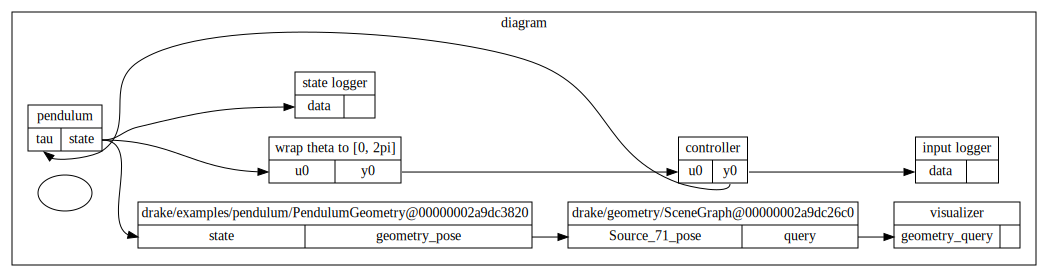

In [10]:
def fitted_value_iteration(
    num_samples={"theta": 50, "theta_dot": 10},
    ranges={
        "theta": (0, 2 * np.pi),
        "theta_dot": (-5, 5),
    },
    input_limit=3,
    num_inputs=10,
    target_state={"theta": np.pi, "theta_dot": 0},
    time_step=0.01,
):
    input_port=0
    Q = np.diag([10, 1])
    R = np.diag([1])

    plant = PendulumPlant()
    plant.CreateDefaultContext()
    simulator = Simulator(plant)

    state_space = create_state_space(num_samples, ranges, target_state)
    pandas_grid = create_pandas_grid(state_space)
    state_grid = [set(v) for v in state_space.values()]
    input_grid = [set(np.append(np.linspace(-input_limit, input_limit, num_inputs), 0))]

    def quadratic_cost(Q, R, target_state):
        def cost(context):
            state = context.get_continuous_state_vector().CopyToVector()
            x = state - target_state
            u = plant.EvalVectorInput(context, input_port).CopyToVector()
            return np.einsum("x,xx,x", x, Q, x) + np.einsum("u,uu,u", u, R, u)

        return cost

    options = DynamicProgrammingOptions()
    options.periodic_boundary_conditions = [
        PeriodicBoundaryCondition(0, 0, 2 * np.pi),
    ]
    options.discount_factor = 0.9999
    options.convergence_tol = 0.1
    options.input_port_index = plant.get_input_port(input_port).get_index()

    policy, cost_to_go = FittedValueIteration(
        simulator,
        quadratic_cost(Q, R, list(target_state.values())),
        state_grid,
        input_grid,
        time_step,
        options,
    )
    pandas_grid["J"] = cost_to_go
    pandas_grid["policy"] = policy.get_output_values().flatten()

    return policy, cost_to_go, pandas_grid


policy, simple_cost_to_go, simple_states = fitted_value_iteration()


def build_simulation(policy):
    # initialize builder
    builder = DiagramBuilder()

    # add pendulum
    scene_graph = builder.AddSystem(SceneGraph())
    plant = builder.AddSystem(PendulumPlant())
    PendulumGeometry.AddToBuilder(builder, plant.get_state_output_port(), scene_graph)
    plant.set_name("pendulum")

    # add the controller
    wrap = builder.AddSystem(WrapToSystem(2))
    wrap.set_name("wrap theta to [0, 2pi]")
    wrap.set_interval(0, 0, 2 * np.pi)
    controller = builder.AddSystem(policy)
    controller.set_name("controller")

    builder.Connect(plant.get_state_output_port(), wrap.get_input_port())
    builder.Connect(wrap.get_output_port(), controller.get_input_port())
    builder.Connect(controller.get_output_port(), plant.get_input_port(0))

    # Add visualizer
    visualizer = builder.AddSystem(
        PlanarSceneGraphVisualizer(
            scene_graph, xlim=[-1.2, 1.2], ylim=[-1.2, 1.2], show=False
        )
    )
    visualizer.set_name("visualizer")
    builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))

    # Add loggers
    state_logger = LogVectorOutput(plant.get_state_output_port(), builder)
    state_logger.set_name("state logger")

    input_logger = LogVectorOutput(controller.get_output_port(), builder)
    input_logger.set_name("input logger")

    # Build the diagram
    diagram = builder.Build()
    diagram.set_name("diagram")

    # Simulate
    simulator = Simulator(diagram)
    simulator.set_publish_every_time_step(False)  # makes sim faster

    return visualizer, simulator, diagram, state_logger, input_logger


visualizer, simulator, diagram, state_logger, input_logger = build_simulation(policy)
visualize_system(diagram)

In [14]:
df = simulate_and_animate(
    {"theta": 0, "theta_dot": 0},
    visualizer,
    simulator,
    state_logger,
    input_logger,
    sim_time=4
)